# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [115]:
# Taking all imports for processing
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb

from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
test_identify_df = pd.read_csv('../data/test_identity.csv')
test_transaction_df = pd.read_csv('../data/test_transaction.csv')

## Part 6 - Prediction Model

In [3]:
def handle_missing_values_in_card6(input_df, is_test_data):
    print("==================== Solving missing values for card6 ====================")
    modified_df = input_df.copy(deep=True)
    if is_test_data:
        nan_indices = modified_df.index[modified_df.card6.isnull()]
        test_card6_replacements = random.choices(['credit', 'debit'], [1, 1], k=nan_indices.shape[0])
        i = 0
        for index in nan_indices:
            modified_df.iloc[index, modified_df.columns.get_loc('card6')] = test_card6_replacements[i]
            if i % 100 == 0:
                print("Test data card6 filling, done with " + str(i) + " , remaining: " + str(len(nan_indices) - i))
            i += 1
    else:
        non_fraud_indices = modified_df.index[((modified_df.isFraud == 0 ) & modified_df.card6.isnull())]
        fraud_indices = modified_df.index[((modified_df.isFraud == 1) & (modified_df.card6.isnull()))]
        print( "Index count: Fraud -> "+ str(fraud_indices.shape) + ", Non-Fraud ->" +  str(non_fraud_indices.shape))

        fraud_card6_replacements = random.choices(['credit', 'debit'], [1, 1], k=fraud_indices.shape[0])
        non_fraud_card6_replacements = random.choices(['credit', 'debit'], [1, 1], k=non_fraud_indices.shape[0])

        i = 0
        for index in fraud_indices:
            modified_df.iloc[index, modified_df.columns.get_loc('card6')] = fraud_card6_replacements[i]
            if i % 100 == 0:
                print("Fraud card6 filling, done with " + str(i) + " , remaining: " + str(len(fraud_indices) - i))
            i += 1

        i = 0
        for index in non_fraud_indices:
            modified_df.iloc[index, modified_df.columns.get_loc('card6')] = non_fraud_card6_replacements[i]
            if i % 100 == 0:
                print("Non fraud card6 filling, done with " + str(i) + " , of: " + str(len(non_fraud_indices) - i))
            i += 1
    
    print("==================== Resolved card6 ====================")
    
    return modified_df

In [4]:
def handle_missing_values_in_card4(input_df, test_data):
    print("==================== Solving missing values for card4 ====================")
    
    modified_df = input_df.copy(deep=True)
    if test_data:
        nan_indices = modified_df.index[modified_df.card4.isnull()]
        test_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [1, 1, 1, 1], k=nan_indices.shape[0])
        i = 0
        for index in nan_indices:
            modified_df.iloc[index, modified_df.columns.get_loc('card4')] = test_card4_replacements[i]
            if i % 100 == 0:
                print("Test data card4 filling, done with " + str(i) + " , remaining: " + str(len(nan_indices) - i))
            i += 1
    else:
        non_fraud_indices = modified_df.index[((modified_df.isFraud == 0 ) & modified_df.card4.isnull())]
        fraud_indices = modified_df.index[((modified_df.isFraud == 1) & (modified_df.card4.isnull()))]
        print( "Index count: Fraud -> "+ str(fraud_indices.shape) + ", Non-Fraud ->" +  str(non_fraud_indices.shape))

        fraud_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [1, 1, 1, 1], k=fraud_indices.shape[0])
        non_fraud_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [1, 1, 1, 1], k=non_fraud_indices.shape[0])

        i = 0
        for index in fraud_indices:
            modified_df.iloc[index, modified_df.columns.get_loc('card4')] = fraud_card4_replacements[i]
            if i % 100 == 0:
                print("Fraud, Filling card4 field, done with " + str(i) + " , of: " + str(len(fraud_indices)))
            i += 1

        i = 0
        for index in non_fraud_indices:
            modified_df.iloc[index, modified_df.columns.get_loc('card4')] = non_fraud_card4_replacements[i]
            if i % 100 == 0:
                print("Fraud, Filling card4 field, done with " + str(i) + " , of: " + str(len(non_fraud_indices)))
            i += 1
    
    print("==================== Resolved card4 ====================")
    
    return modified_df

In [5]:
def handle_missing_values_in_addr(input_df):
    print("==================== Solving missing values for addr1/addr2 ====================")
    
    modified_df = input_df.copy(deep=True)
    
    modified_df['addr1'] = modified_df['addr1'].fillna('special_region')
    modified_df['addr2'] = modified_df['addr2'].fillna('special_country')
    
    print("==================== Resolved addr1/addr2 ====================")
    
    return modified_df

In [7]:
def handle_emails(input_df):
    modified_df = input_df.copy(deep=True)
    
    email_domain_map = {
	'gmail.com': ['gmail.com', 'gmail'], 
  	'yahoo.com': ['yahoo.com', 'yahoo.com.mx', 'ymail.com', 'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.co.uk', 'yahoo.co.jp'] , 
  	'hotmail.com': ['hotmail.com', 'outlook.com', 'live.com.mx', 'hotmail.es', 'msn.com', 'live.com', 'outlook.es', 'hotmail.de', 'hotmail.fr', 'hotmail.co.uk'],
  	'netzero.net': ['netzero.com', 'netzero.net'] ,
  	'icloud.com': ['mac.com', 'icloud.com']
    }

    reverse_email_domain_map = {}
    for root_domain in email_domain_map:
        for domain in email_domain_map[root_domain]:
            reverse_email_domain_map[domain] = root_domain
    # reverse_email_domain_map

    modified_df['P_emaildomain'] = modified_df['P_emaildomain'].fillna('special_purchaser_email')
    modified_df['R_emaildomain'] = modified_df['R_emaildomain'].fillna('special_receipient_email')
  
    modified_df['P_emaildomain'] = modified_df['P_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)
    modified_df['R_emaildomain'] = modified_df['R_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)
    
    return modified_df

In [8]:
pass

In [9]:
def drop_columns(input_df, column_names):
    print("==================== Dropping some columns ====================")
    return input_df.drop(column_names, axis = 1) # non-inplace drop, the input_df will still have its all columns

In [10]:
def one_hot_encode(df, col_name, col_prefix=''):
    print("==================== Encoding "+ col_name + " ====================")
    
    if len(col_prefix) > 0:
        one_hot_encoding = pd.get_dummies(df[col_name], prefix=col_prefix)
    else:
        one_hot_encoding = pd.get_dummies(df[col_name])
    new_df = df.copy(deep=True)
    new_df = new_df.drop(col_name, axis=1)
    new_df = new_df.join(one_hot_encoding)
    
    return new_df

In [11]:
def encode_categorical_fields(input_df):
    print("==================== Encoding categorical columns ====================")
    pre_processing_df = input_df.copy(deep=True)
    
    pre_processing_df = one_hot_encode(pre_processing_df, 'card4')
    pre_processing_df = one_hot_encode(pre_processing_df, 'card6')
    pre_processing_df = one_hot_encode(pre_processing_df, 'ProductCD')
    pre_processing_df = one_hot_encode(pre_processing_df, 'DeviceType')
    pre_processing_df = one_hot_encode(pre_processing_df, 'addr1', col_prefix='addr1_')
    pre_processing_df = one_hot_encode(pre_processing_df, 'addr2', col_prefix='addr2_')
    pre_processing_df = one_hot_encode(pre_processing_df, 'P_emaildomain', col_prefix='P_emaildomain_')
    pre_processing_df = one_hot_encode(pre_processing_df, 'R_emaildomain', col_prefix='R_emaildomain_')
    
    print("==================== Done encoding categorical fields ====================")

    return pre_processing_df

In [12]:
def pre_process_df(identity_df, transaction_df):
    print("==================== Pre-Processing begins! ====================")
    
    global_df = pd.merge(left=transaction_df, right=identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
    basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]
    modified_df = basic_fields_df.copy(deep=True)
    print("Pre-Processing initial shape: " + str(modified_df.shape))
    
    modified_df = handle_missing_values_in_card6(modified_df, False)
    modified_df = handle_missing_values_in_card4(modified_df, False)
    modified_df = handle_missing_values_in_addr(modified_df)
    modified_df = handle_emails(modified_df)
    
    pre_processing_df = drop_columns(modified_df, ['TransactionID', 'dist1', 'dist2', 'DeviceInfo'])
    pre_processing_df = encode_categorical_fields(pre_processing_df)
    
    print("Pre-Processing final shape: " + str(pre_processing_df.shape))
    print("==================== Done Pre-Processing ====================")
    
    
    return pre_processing_df
    

In [13]:
def add_missing_dummy_columns(test_df, train_columns ):
    missing_cols = set(train_columns) - set(test_df.columns)
    for c in missing_cols:
        test_df[c] = 0

In [14]:
# Citation: http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
def fix_columns(test_df, train_df):  

    add_missing_dummy_columns(test_df, train_df.columns)

    # make sure we have all the columns we need
    assert(set(train_df.columns) - set( test_df.columns ) == set())

    extra_cols = set(test_df.columns) - set(train_df.columns)
    if extra_cols:
        print("extra columns:", extra_cols)

    test_df = test_df[train_df.columns]
    return test_df

In [15]:
def pre_process_test_df(identity_df, transaction_df, train_df):
    print("==================== Pre-Processing begins! ====================")
    
    global_df = pd.merge(left=transaction_df, right=identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
    basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                                  "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                                  "addr1", "addr2", "dist1", "dist2", "DeviceType", "DeviceInfo"]]

    modified_df = basic_fields_df.copy(deep=True)
    print("Pre-Processing initial shape: " + str(modified_df.shape))
    
    modified_df = handle_missing_values_in_card6(modified_df, True)
    modified_df = handle_missing_values_in_card4(modified_df, True)
    modified_df = handle_missing_values_in_addr(modified_df)
    modified_df = handle_emails(modified_df)
    
    pre_processing_df = drop_columns(modified_df, ['TransactionID', 'dist1', 'dist2', 'DeviceInfo'])
    pre_processing_df = encode_categorical_fields(pre_processing_df)
    pre_processing_df = fix_columns(pre_processing_df, train_df)
    
    print("Pre-Processing final shape: " + str(pre_processing_df.shape))
    print("==================== Done Pre-Processing ====================")
    
    
    return pre_processing_df
    

In [16]:
def split_dataset(df):
    input_dataset_x = df.drop(['isFraud'], axis=1)
    input_dataset_y = df['isFraud']
    return train_test_split(input_dataset_x, input_dataset_y, random_state=31) # returns X_train, X_test, y_train, y_test

In [123]:
def plot_confusion_matrix(y_test, y_predictions):
    mat = confusion_matrix(y_test, y_predictions)
    print("Confusion Marix: ")
    print(str(mat))
    sns.heatmap(mat, cmap="YlGnBu")
    plt.tight_layout()
    
    return mat

In [18]:
def oversample_fraud(X_train, y_train, X_test, y_test, proportion = 1.0):
    X = pd.concat([X_train, y_train], axis=1)
    not_fraud = X[X.isFraud == 0]
    fraud = X[X.isFraud == 1]
    len_fraud_samples = int(proportion * not_fraud.shape[0])
    print("Shape before oversampling fraud dataset: Fraud -> " + str(fraud.shape) + ", Non-Fraud -> " + str(not_fraud.shape))
    print("Oversampling fraud samples -> " + str(len_fraud_samples))
    fraud_oversample = resample(fraud, replace=True, n_samples=len_fraud_samples, random_state=31)
    oversampled = pd.concat([not_fraud, fraud_oversample])
    print("Shape after merging oversampled fraud and non-fraud -> " + str(oversampled.shape))
    return oversampled
    

In [21]:
def sample_and_split(pre_processed_df):
    X_train, X_test, y_train, y_test = split_dataset(pre_processed_df)
    oversampled = oversample_fraud(X_train, y_train, X_test, y_test, proportion=0.5)
    X_train, X_test, y_train, y_test = split_dataset(oversampled)
    
    return X_train, X_test, y_train, y_test

In [37]:
def xgb_classifer(pre_processed_df):
    print("==================== Training begins! ====================")
    X_train, X_test, y_train, y_test = sample_and_split(pre_processed_df)
    
    xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    xgb_classifier.fit(X_train, y_train)
    
    print("==================== Training done! ====================")
    
    return xgb_classifier

In [22]:
def train_classifer(pre_processed_df):
    print("==================== Training begins! ====================")
    X_train, X_test, y_train, y_test = sample_and_split(pre_processed_df)
    
    dt_classifier = tree.DecisionTreeClassifier()
    dt_classifier = dt_classifier.fit(X_train, y_train)
    
    print("==================== Training done! ====================")
    
    return dt_classifier
    

In [23]:
pre_processed_df = pre_process_df(train_identity_df, train_transaction_df)

==================== Pre-Processing begins! ====================
Pre-Processing initial shape: (590540, 15)
==================== Solving missing values for card6 ====================
Index count: Fraud -> (39,), Non-Fraud ->(1532,)
Fraud card6 filling, done with 0 , remaining: 39
Non fraud card6 filling, done with 0 , of: 1532
Non fraud card6 filling, done with 100 , of: 1432
Non fraud card6 filling, done with 200 , of: 1332
Non fraud card6 filling, done with 300 , of: 1232
Non fraud card6 filling, done with 400 , of: 1132
Non fraud card6 filling, done with 500 , of: 1032
Non fraud card6 filling, done with 600 , of: 932
Non fraud card6 filling, done with 700 , of: 832
Non fraud card6 filling, done with 800 , of: 732
Non fraud card6 filling, done with 900 , of: 632
Non fraud card6 filling, done with 1000 , of: 532
Non fraud card6 filling, done with 1100 , of: 432
Non fraud card6 filling, done with 1200 , of: 332
Non fraud card6 filling, done with 1300 , of: 232
Non fraud card6 filling, 

In [24]:
X_train, X_test, y_train, y_test = sample_and_split(pre_processed_df)

Shape before oversampling fraud dataset: Fraud -> (15568, 509), Non-Fraud -> (427337, 509)
Oversampling fraud samples -> 213668
Shape after merging oversampled fraud and non-fraud -> (641005, 509)


In [25]:
dt_classifier = tree.DecisionTreeClassifier()
dt_classifier = dt_classifier.fit(X_train, y_train)

Confusion Marix: 
[[ 53127      0]
 [  2711 104414]]
Decision Tree accuracy: 0.9830828944412551
Precision-Recall-Fscore-Support -> (0.9514488341272969, 1.0, 0.9751204515211307, None)


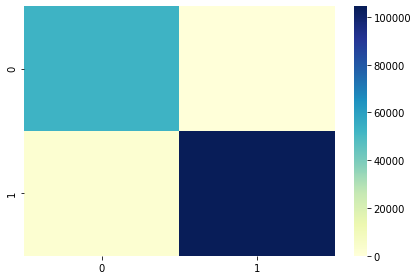

In [26]:
y_predictions = dt_classifier.predict(X_test)
accuracy_score = dt_classifier.score(X_test, y_test)
confusion_mat = plot_confusion_matrix(y_test, y_predictions)
print("Decision Tree accuracy: " + str(accuracy_score))
prfs = precision_recall_fscore_support(y_test, y_predictions, average='binary')
print("Precision-Recall-Fscore-Support -> " + str(prfs))

### Citation:
1.  https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

In [42]:
X_train, X_test, y_train, y_test = sample_and_split(pre_processed_df)

rf_classifier = RandomForestClassifier(random_state=13)
rf_classifier = rf_classifier.fit(X_train, y_train)

Shape before oversampling fraud dataset: Fraud -> (15568, 509), Non-Fraud -> (427337, 509)
Oversampling fraud samples -> 213668
Shape after merging oversampled fraud and non-fraud -> (641005, 509)


C:\Users\Paras\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Citation:
1. https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t5

In [92]:
# Oversampling with SMOTE
X_train, X_test, y_train, y_test = split_dataset(pre_processed_df)
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(random_state=13)
rf_classifier = rf_classifier.fit(X_resampled, y_resampled)

C:\Users\Paras\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [96]:
y_resampled.shape

(854674,)

In [89]:
y_train.shape

(480753,)

In [113]:
# # Undersampling with ClusterCentroid
# X_train, X_test, y_train, y_test = split_dataset(pre_processed_df)

# print("splitting over")

# cc = ClusterCentroids(random_state=23, sampling_strategy=0.2)
# X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

# print("Resample over")

Confusion Marix: 
[[  2463   2632]
 [   998 141542]]
Random Forest accuracy: 0.9754123344735327
Precision-Recall-Fscore-Support -> (0.7116440335163248, 0.4834151128557409, 0.5757363253856942, None)


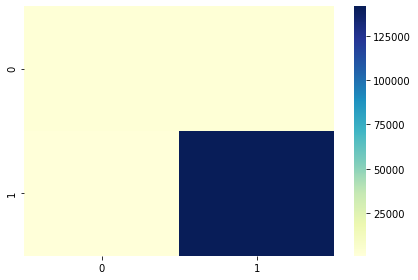

In [94]:
y_predictions = rf_classifier.predict(X_test)
accuracy_score = rf_classifier.score(X_test, y_test)
confusion_mat = plot_confusion_matrix(y_test, y_predictions)
print("Random Forest accuracy: " + str(accuracy_score))
prfs = precision_recall_fscore_support(y_test, y_predictions, average='binary')
print("Precision-Recall-Fscore-Support -> " + str(prfs))

In [27]:
test_pre_processed_df = pre_process_test_df(test_identify_df, test_transaction_df, X_train)

==================== Pre-Processing begins! ====================
Pre-Processing initial shape: (506691, 14)
==================== Solving missing values for card6 ====================
Test data card6 filling, done with 0 , remaining: 3007
Test data card6 filling, done with 100 , remaining: 2907
Test data card6 filling, done with 200 , remaining: 2807
Test data card6 filling, done with 300 , remaining: 2707
Test data card6 filling, done with 400 , remaining: 2607
Test data card6 filling, done with 500 , remaining: 2507
Test data card6 filling, done with 600 , remaining: 2407
Test data card6 filling, done with 700 , remaining: 2307
Test data card6 filling, done with 800 , remaining: 2207
Test data card6 filling, done with 900 , remaining: 2107
Test data card6 filling, done with 1000 , remaining: 2007
Test data card6 filling, done with 1100 , remaining: 1907
Test data card6 filling, done with 1200 , remaining: 1807
Test data card6 filling, done with 1300 , remaining: 1707
Test data card6 f

In [28]:
test_pre_processed_df.head(1)

,TransactionDT,TransactionAmt,american express,discover,mastercard,visa,charge card,credit,debit,debit or credit,...,R_emaildomain__sc.rr.com,R_emaildomain__scranton.edu,R_emaildomain__servicios-ta.com,R_emaildomain__special_receipient_email,R_emaildomain__suddenlink.net,R_emaildomain__twc.com,R_emaildomain__verizon.net,R_emaildomain__web.de,R_emaildomain__windstream.net,R_emaildomain__yahoo.com
0,18403224,31.95,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [116]:
# Undersampling with RandomSampler
X_train, X_test, y_train, y_test = split_dataset(pre_processed_df)

print("splitting over")

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

print("Resample over")

splitting over
Resample over


In [117]:
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_classifier.fit(X_rus, y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

XGB accuracy: 0.7797338029600027
Confusion Marix: 
[[111674  30866]
 [  1653   3442]]
Precision-Recall-Fscore-Support -> (0.10032645447126035, 0.6755642787046123, 0.1747075095804888, None)


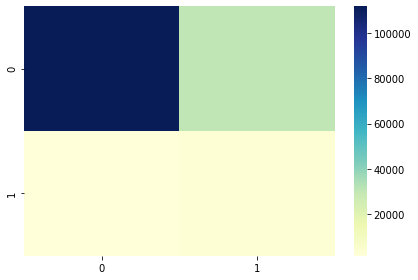

In [124]:
y_predictions = xgb_classifier.predict(X_test.values)
accuracy_score = xgb_classifier.score(X_test.values, y_test.values)
print("XGB accuracy: " + str(accuracy_score))
confusion_mat = plot_confusion_matrix(y_test, y_predictions)
prfs = precision_recall_fscore_support(y_test, y_predictions, average='binary')
print("Precision-Recall-Fscore-Support -> " + str(prfs))

In [119]:
X_train.shape

(442905, 508)

In [97]:
rf_predictions_score = rf_classifier.predict_proba(test_pre_processed_df)

In [100]:
rf_predictions_score

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [0.9, 0.1],
       [0.9, 0.1]])

In [106]:
result = pd.DataFrame({"TransactionID": test_transaction_df["TransactionID"], "isFraud": rf_predictions_score[:, 1]})

In [108]:
result.to_csv("submission.csv", index=False, header=True)

In [53]:
rf_classifier.predict(test_pre_processed_df)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [29]:
predictions_score = dt_classifier.predict_proba(test_pre_processed_df)

In [155]:
test_transaction_df.shape

(506691, 393)

In [168]:
output_df = pd.DataFrame({"TransactionID": test_transaction_df["TransactionID"]})

In [170]:
output_df["isFraud"] = pd.Series(np.array(predictions_score[:, 0]))

In [174]:
output_df.to_csv(path_or_buf="submission.csv", index=False)

In [175]:
test_transaction_df.shape

(506691, 393)

In [126]:
xgb_predictions_score = xgb_classifier.predict_proba(test_pre_processed_df.values)

In [128]:
result = pd.DataFrame({"TransactionID": test_transaction_df["TransactionID"], "isFraud": xgb_predictions_score[:, 1]})
result.to_csv("submission.csv", index=False, header=True)